In [309]:
import pandas as pd
import random
import pickle
import time


In [310]:
df = pd.read_csv(r"/home/abhishek/Desktop/24144001_CSOC_IG/prerequisites/housing.csv")

In [311]:
df.head(500)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
495,-122.25,37.86,52.0,4048.0,663.0,1316.0,590.0,5.3794,376900.0,NEAR BAY
496,-122.26,37.85,52.0,3618.0,768.0,1508.0,755.0,3.2619,309600.0,NEAR BAY
497,-122.27,37.85,52.0,4076.0,920.0,1800.0,815.0,2.7054,182300.0,NEAR BAY
498,-122.27,37.85,47.0,2077.0,400.0,719.0,326.0,2.2431,172700.0,NEAR BAY


In [312]:
print(df.isnull().sum())


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [313]:
print("Before:", df.shape)
df.dropna(inplace=True)
print("After:", df.shape) # to remove any rows with any nan values


Before: (20640, 10)
After: (20433, 10)


In [314]:
print(df['ocean_proximity'].unique())


['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


In [315]:
mappr = {
    'NEAR BAY': 0,
    '<1H OCEAN': 1,
    'INLAND': 2,
    'NEAR OCEAN': 3,
    'ISLAND': 4
}

# Now replace the values in the column
df['ocean_proximity'] = df['ocean_proximity'].map(mappr)


In [316]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0


In [317]:
X = df[["longitude", "latitude",	"housing_median_age",	"total_rooms",	"total_bedrooms",	"population",	"households",	"median_income"	,	"ocean_proximity"]].values.tolist()
y = df["median_house_value"].tolist()

In [318]:
def get_random_weights(n):
    random.seed(42)
    weights = [random.uniform(-0.1, 0.1) for _ in range(n)]
    bias = random.uniform(-0.1, 0.1)
    return weights, bias

initial_weights, initial_bias = get_random_weights(n=9)
print(initial_bias)
print(initial_weights)


-0.09404055611238593
[0.02788535969157674, -0.09499784895546662, -0.04499413632617615, -0.05535785237023545, 0.04729424283280248, 0.03533989748458227, 0.0784359135409691, -0.08261223347411678, -0.015615636062945915]


so above is the randomly generated initial weights and bias

now save this stuff in a file

In [319]:
import numpy as np

# save weights and biass for future use in binary file
np.save("initial_weights.npy", np.array(initial_weights))
np.save("initial_bias.npy", np.array(initial_bias))


In [320]:
#prediction function
def predict_single(xi, weights, bias):
    return sum(w * x for w, x in zip(weights, xi)) + bias

def predict_batch(X, weights, bias):
    return [predict_single(xi, weights, bias) for xi in X]


In [321]:
#loss function
def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    return sum((yt - yp) ** 2 for yt, yp in zip(y_true, y_pred)) / n


In [322]:
def compute_gradients(X, y_true, y_pred):
    n = len(y_true)
    n_features = len(X[0])
    dw = [0.0] * n_features
    db = 0.0

    for xi, yi, y_hat in zip(X, y_true, y_pred):
        error = y_hat - yi
        for j in range(n_features):
            dw[j] += error * xi[j]
        db += error

    dw = [d / n for d in dw]
    db /= n
    return dw, db


In [323]:
def train(X, y, weights, bias, learning_rate=0.01, epochs=100):
    cost_history = []

    for epoch in range(epochs):
        y_pred = predict_batch(X, weights, bias)
        cost = mean_squared_error(y, y_pred)
        dw, db = compute_gradients(X, y, y_pred)

        weights = [w - learning_rate * grad for w, grad in zip(weights, dw)]
        bias = bias - learning_rate * db

        cost_history.append(cost)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Cost: {cost}")

    return weights, bias, cost_history


In [324]:
#mae formula
def mae(y_true, y_pred):
    m = len(y_true)
    absolute_errors = [abs(yt - yp) for yt, yp in zip(y_true, y_pred)]
    return sum(absolute_errors) / m


In [325]:
#rmse formuila
import math

def rmse(y_true, y_pred):
    m = len(y_true)
    squared_errors = [(yt - yp) ** 2 for yt, yp in zip(y_true, y_pred)]
    mse = sum(squared_errors) / m
    return math.sqrt(mse)


In [326]:
#r2 score formula
def r2(y_true, y_pred):
    mean_y = sum(y_true) / len(y_true)
    ss_total = sum((yt - mean_y) ** 2 for yt in y_true)
    ss_residual = sum((yt - yp) ** 2 for yt, yp in zip(y_true, y_pred))
    return 1 - (ss_residual / ss_total)


In [327]:
def train_test_split_along_with_indices(X, y, test_ratio=0.2, seed=42):
    import random
    random.seed(seed)
    indices = list(range(len(X)))
    random.shuffle(indices)
    split = int(len(X) * (1 - test_ratio))
    train_idx, test_idx = indices[:split], indices[split:]

    X_train = [X[i] for i in train_idx]
    y_train = [y[i] for i in train_idx]
    X_test = [X[i] for i in test_idx]
    y_test = [y[i] for i in test_idx]
    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [328]:
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split_along_with_indices(X, y, test_ratio=0.2, seed=42)
with open("split_indices.pkl", "wb") as f:
    pickle.dump((train_idx, test_idx), f)

In [329]:
weights, bias, cost_history = train(X_train, y_train, initial_weights, initial_bias, learning_rate=0.000001, epochs=100)


Epoch 0, Cost: 56397845634.338715
Epoch 10, Cost: 7.667319359364348e+33
Epoch 20, Cost: 2.0593382106829435e+57
Epoch 30, Cost: 5.531103723753826e+80
Epoch 40, Cost: 1.4855796024285665e+104
Epoch 50, Cost: 3.990065754279589e+127
Epoch 60, Cost: 1.0716776601838019e+151
Epoch 70, Cost: 2.878381154759758e+174
Epoch 80, Cost: 7.730942222547831e+197
Epoch 90, Cost: 2.0764264506644126e+221


In [330]:
def normalize_features(X):
    n_features = len(X[0])
    means = [sum(x[i] for x in X) / len(X) for i in range(n_features)]
    stds = []
    for i in range(n_features):
        variance = sum((x[i] - means[i])**2 for x in X) / len(X)
        stds.append(variance**0.5 if variance > 0 else 1)
    
    X_norm = []
    for xi in X:
        normalized = [(xi[i] - means[i]) / stds[i] for i in range(n_features)]
        X_norm.append(normalized)
    return X_norm, means, stds

X_train_norm, means, stds = normalize_features(X_train)

# Normalize test set using same train means and stds:
def normalize_with_params(X, means, stds):
    X_norm = []
    for xi in X:
        normalized = [(xi[i] - means[i]) / stds[i] for i in range(len(xi))]
        X_norm.append(normalized)
    return X_norm

X_test_norm = normalize_with_params(X_test, means, stds)


In [331]:
import pandas as pd

# Create a DataFrame from X_train
train_df = pd.DataFrame(X_train, columns=X)
test_df = pd.DataFrame(X_test, columns=X)


In [332]:
means = train_df.mean()
stds = train_df.std()


In [333]:
X_train_normalized = ((train_df - means) / stds).values.tolist()
X_test_normalized = ((test_df - means) / stds).values.tolist()


In [334]:
start_time = time.time()

weights, bias, cost_history = train(
    X_train_normalized,
    y_train,
    initial_weights,
    initial_bias,
    learning_rate=0.3,
    epochs=1000
)

end_time = time.time()

print(f"fitting time for pure python implementation is: {end_time - start_time:.4f} seconds")


Epoch 0, Cost: 56378095811.23393
Epoch 10, Cost: 5811651169.430702
Epoch 20, Cost: 5433295088.895221
Epoch 30, Cost: 5235580021.583471
Epoch 40, Cost: 5113738160.735052
Epoch 50, Cost: 5037120917.31106
Epoch 60, Cost: 4988196183.979415
Epoch 70, Cost: 4956540364.815815
Epoch 80, Cost: 4935804720.222522
Epoch 90, Cost: 4922053275.855397
Epoch 100, Cost: 4912813340.218563
Epoch 110, Cost: 4906515330.879802
Epoch 120, Cost: 4902154249.547701
Epoch 130, Cost: 4899081511.827003
Epoch 140, Cost: 4896875314.220774
Epoch 150, Cost: 4895259149.708495
Epoch 160, Cost: 4894050211.271817
Epoch 170, Cost: 4893126517.174885
Epoch 180, Cost: 4892405844.978999
Epoch 190, Cost: 4891832156.305758
Epoch 200, Cost: 4891366797.391007
Epoch 210, Cost: 4890982759.396302
Epoch 220, Cost: 4890660908.897556
Epoch 230, Cost: 4890387493.771586
Epoch 240, Cost: 4890152479.536122
Epoch 250, Cost: 4889948429.891857
Epoch 260, Cost: 4889769746.390608
Epoch 270, Cost: 4889612146.9098835
Epoch 280, Cost: 4889472304.236

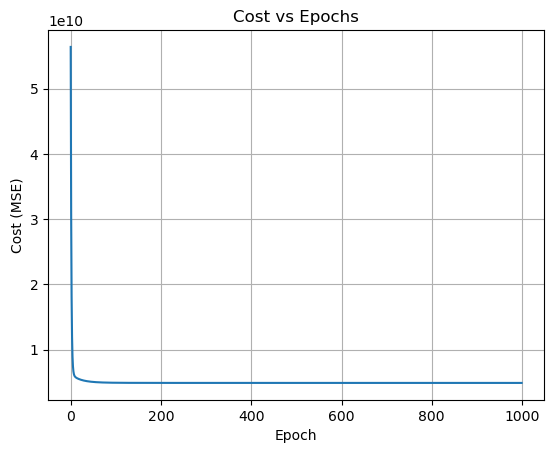

In [335]:
import matplotlib.pyplot as plt

plt.plot(range(len(cost_history)), cost_history)
plt.xlabel("Epoch")
plt.ylabel("Cost (MSE)")
plt.title("Cost vs Epochs")
plt.grid(True)
plt.show()


In [ ]:
plt.savefig('purepython_cost_vs_epoch.png')


<Figure size 640x480 with 0 Axes>

In [336]:
y_pred_test = predict_batch(X_test_normalized, weights, bias)
y_pred_train = predict_batch(X_train_normalized, weights, bias)


In [337]:
mae_train = mae(y_train, y_pred_train)
rmse_train = rmse(y_train, y_pred_train)
r2_train = r2(y_train, y_pred_train)

print("for train")
print("MAE:", mae_train)
print("RMSE:", rmse_train)
print("R2:", r2_train)


for train
MAE: 51014.60689613549
RMSE: 69915.18059428954
R2: 0.6328571488870136


In [338]:
mae = mae(y_test, y_pred_test)
rmse = rmse(y_test, y_pred_test)
r2 = r2(y_test, y_pred_test)
print("for test")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


for test
MAE: 50341.61125316037
RMSE: 67983.98892062738
R2: 0.6540349282604752


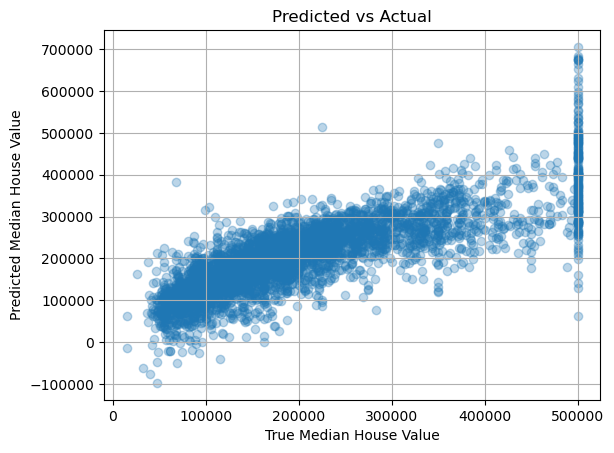

In [339]:
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.xlabel("True Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()


In [341]:
plt.savefig('purepython_scatterplot.png')


<Figure size 640x480 with 0 Axes>